In [24]:
#Q1 Implement SVM from scratch

import numpy as np
import random
import matplotlib.pyplot as plt                                 #To plot scatter plot
from scipy.optimize import minimize, LinearConstraint           #For SVM optimization
from scipy.optimize import Bounds, BFGS                         #For SVM optimization

In [25]:
#1.1 Generate and visualize data
def gen_data():
    np.random.seed(105)
    Positive = np.concatenate((np.random.randn(10, 2) * 0.4 + [1.5, -0.5],
                             np.random.randn(10, 2) * 0.4 + [-1.5, 0.5]))
    Negative = np.random.randn(20, 2) * 0.3 + [0.0, -0.9]

    return Positive, Negative

In [26]:
#1.2 Plot data
def plot_data(Positive, Negative):
  x_axis_range = np.linspace(-2.5, 2.5, 20)
  plt.scatter(Positive[:, 0], Positive[:, 1], color = "b")
  plt.scatter(Negative[:, 0], Negative[:, 1], color = "r")

In [27]:
#1.3 Fit SVM with linear kernel with slack variable
def lagrange_dual(alpha, x, y):
    ZERO = 1e-7
    result = 0
    non_zero_alphas = np.where(alpha > ZERO)[0]
    for i in non_zero_alphas:
        for k in non_zero_alphas:
            #result = result + alpha[i]*alpha[k]*y[i]*y[k]*np.dot(x[i, :], x[k, :]) 
            result = result + alpha[i]*alpha[k]*y[i]*y[k]*linear_kernel(x[i, :], x[k, :])
    result = 0.5*result - sum(alpha)     
    return result

In [28]:
def linear_kernel(x, y, **kwargs):
    # insert your code here 
    # return linear kernel output
    return np.dot(x, y)

In [29]:
def fit(X, Y, C=None, kernel=None, kwargs = {}):
    '''
    X: input_data (Nx2) numpy array
    Y: binary target variable (N,) numpy array
    C: The slack variable
    kernel: kernel function (linear or polynomial)
    kwargs: dictionary of arguments
    '''
    # insert your code here
    # Apply optimization of dual function (Equation 7.10: Bishop)
    # make use of minimize()
    # 
    m, n = X.shape
    np.random.seed(1)
    
    alpha_0 = np.random.rand(m)*C                       # Initialize alphas to random values
    linear_constraint = LinearConstraint(Y, [0], [0])   # Define the constraint
    bounds_alpha = Bounds(np.zeros(m), np.full(m, C))   # Define the bounds

    # Find the optimal value of alpha
    result = minimize(lagrange_dual, alpha_0, args = (X, Y), method='trust-constr', 
                      hess=BFGS(), constraints=[linear_constraint],
                      bounds=bounds_alpha)
    
    # The optimized value of alpha lies in result.x
    alpha = result.x
    return alpha


In [30]:
#Q1.4 Linear Kernel decision boundary visualization

def get_support_vectors(X, Y, lambdas, threshold=10e-5):
  # insert your code here
  # return support vectors, target variable values of the support vectors, lambdas of support vectoss
  # remeber only lambdas >=0 are to be kept
  s_vecs =  np.array([]); s_vecs_Y =  np.array([]); s_vecs_lambda =  np.array([])

  for x, y, lambda_m in zip (X, Y, lambdas):
    if lambda_m > threshold:
      s_vecs = np.append(s_vecs, x)
      s_vecs_Y = np.append(s_vecs_Y, y)
      s_vecs_lambda = np.append(s_vecs_lambda, lambda_m)

  return np.reshape(s_vecs, (-1, 2)), s_vecs_Y, s_vecs_lambda     #reshape a flattened s_vecs into shape = 2, 1
 


X [[ 1.40186973 -0.74534088]
 [ 1.20929285 -0.47625357]
 [ 1.90223209 -0.55125585]
 [ 0.88640301 -0.31171598]
 [ 1.2778755  -0.58188648]
 [ 2.18190517  0.52953827]
 [ 1.72225459 -0.11974027]
 [ 0.93775459  0.06812878]
 [ 0.98524228 -0.44313042]
 [ 1.77592671 -0.62091129]
 [-2.1300322   0.61799457]
 [-1.14212888 -0.19215842]
 [-1.53690053  1.07849279]
 [-0.76590095  1.12063704]
 [-1.25314624  0.7644046 ]
 [-1.44369968  1.3358034 ]
 [-2.01477484  0.55726986]
 [-1.247687    0.60864115]
 [-2.03524537  0.56015045]
 [-1.44075191  0.15927811]
 [-0.10434967 -0.80116922]
 [-0.20376774 -0.82076316]
 [ 0.58299574 -1.22404863]
 [-0.04612834 -0.43374017]
 [-0.28625899 -1.15067218]
 [ 0.07112504 -1.01239012]
 [ 0.42448628 -0.86445712]
 [ 0.28036696 -1.35396003]
 [-0.71154051 -0.54219998]
 [-0.18664454 -1.2922903 ]
 [ 0.07742877 -1.14931829]
 [-0.6251601  -1.42210023]
 [-0.11132172 -1.48342931]
 [-0.43042553 -0.1224234 ]
 [-0.00892175 -0.71463001]
 [ 0.25602264 -1.35327514]
 [-0.59376991 -0.84960436]

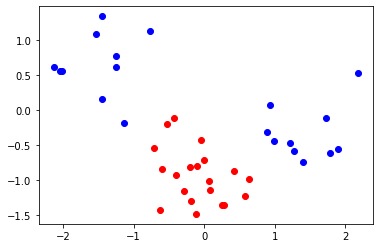

In [31]:
# Test code
if __name__ == '__main__':
    Positive, Negative = gen_data()
    plot_data(Positive, Negative)
    
    X = np.concatenate((Positive, Negative))
    target_data = np.concatenate((np.ones(Positive.shape[0]), -np.ones(Negative.shape[0])))

    size = X.shape[0]
    shuffle_data = list(range(size))      #range(40) means numbers  0 - 39 are created and listed
    random.shuffle(shuffle_data)
    X = X[shuffle_data, :]
    Y = target_data[shuffle_data]

    lambdas = fit(X, Y, C=5,  kernel=linear_kernel, kwargs={})    # C is slack variable
               
    # Get the alpha values for the support vectors, as well as their target data.
    s_vecs, s_vecs_Y, s_vecs_lambda = get_support_vectors(X, Y, lambdas)
    print(f"{s_vecs.shape[0]} support vectors found.\\n", s_vecs)
    '''
    # test new data point
    ip_new = np.array([-0.6, 0.75])
    prediciton = predict(ip_new,
                         s_vecs,
                         s_vecs_Y,
                         s_vecs_lambda,
                         kernel=linear_kernel,
                         kwargs={})

    plot_decision_boundary(  Positive, Negative,
                             ip_new,
                             s_vecs,
                             s_vecs_Y,
                             s_vecs_lambda,
                             kernel=linear_kernel,
                             kwargs={})
  '''
